In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as sps
import pandas as pd
from scipy.special import factorial
import warnings
warnings.simplefilter('ignore')
%matplotlib inline


Условие - https://drive.google.com/open?id=13rYyMotOtFTeZBSXwOLOwNBmB9yXjdBY


# Задача №1


Объявление глобальных переменных и параметров эксперимента.


norm is ready...
gamma is ready...
uniform is ready...
poisson is ready...
bin is ready...
geom is ready...
beta is ready...


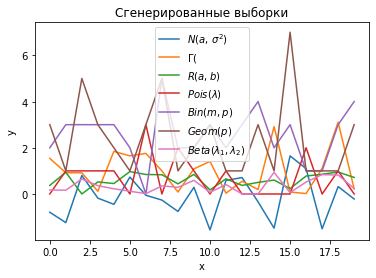

In [30]:
distribution_key = 'dist'
params_key = 'params'
estimators_func_key = 'est_func'

randvar_count = 1000
sample_count = 1
K = 1000


Для каждого распределения свои оценки методом моментов, они записаны в этих функциях.
Позже мы будем ими пользоваться. В них оценка для одной случайной величины.


norm is ready...
gamma is ready...
uniform is ready...
poisson is ready...
bin is ready...
geom is ready...
beta is ready...


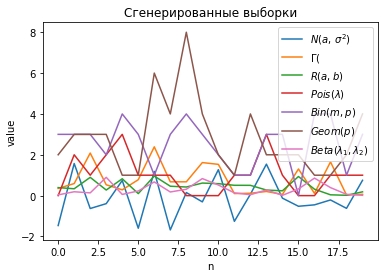

In [33]:
def get_norm_estimators(array: np.array):
    return (array.mean(), (array**2).mean() - array.mean()**2)

def get_gamma_estimators(array: np.array):
    return (np.mean(array) - (3 * (np.mean(array ** 2) - np.mean(array) ** 2)) ** 0.5, 
               np.mean(array) + (3 * (np.mean(array ** 2) - np.mean(array) ** 2)) ** 0.5)

def get_uniform_estimators(array: np.array):
    return (np.mean(array) - (3 * (np.mean(array ** 2) - np.mean(array) ** 2)) ** 0.5, 
               np.mean(array) + (3 * (np.mean(array ** 2) - np.mean(array) ** 2)) ** 0.5)

def get_poisson_estimators(array: np.array):
    return np.mean(array)

def get_binom_estimators(array: np.array):
    return (np.mean(array) ** 2 / (np.mean(array) ** 2 - np.mean(array ** 2) + np.mean(array)), 
               (np.mean(array) ** 2 -  np.mean(array ** 2) + np.mean(array)) / np.mean(array))

def get_geom_estimators(array: np.array):
    return 1 / np.mean(array)

def get_beta_estimators(sample: np.array):
    return ((np.mean(sample ** 2) * np.mean(sample) - \
            np.mean(sample) ** 2) / (np.mean(sample) ** 2  \
                                     - np.mean(sample ** 2)), 
           (np.mean(sample ** 2) - np.mean(sample)) * \
            (1 - np.mean(sample)) / (np.mean(sample) ** 2 - \
                                     np.mean(sample ** 2)))


get_estimators() вычисляет оценки для всех n. Здесь в функции gen_distributions мы генерируем наши выборки.


In [ ]:
def get_estimators(sample, estimators_func):
    params = [estimators_func(sample[:n]) for n in range(1, sample.shape[0])]
    params.append(estimators_func(sample))
    return params

def gen_distribution(np_distrib, get_estimators_func, **kwargs):
    distribution = np_distrib.rvs(size=randvar_count, **kwargs)
    params = [get_estimators_func(distribution[:n]) for n in range(1, distribution.shape[0])]
    params.append(get_estimators_func(distribution))
    
    return {distribution_key: distribution, params_key: np.array(params),
            estimators_func_key: get_estimators_func}

def gen_distributions() -> dict:
    result = {}
    result['$N(a,\,\sigma^{2})$'] = gen_distribution(sps.norm, get_norm_estimators)
    print('norm is ready...')
    result['$\Gamma(\alpha, \lambda)$'] = gen_distribution(sps.gamma(a=1), get_gamma_estimators)
    print('gamma is ready...')
    result['$R(a, b)$'] = gen_distribution(sps.uniform, get_uniform_estimators)
    print('uniform is ready...')
    result['$Pois(\lambda)$'] = gen_distribution(sps.poisson(mu=1), get_poisson_estimators)
    print('poisson is ready...')
    result['$Bin(m, p)$'] = gen_distribution(sps.binom(5, 0.5), get_binom_estimators)
    print('bin is ready...')
    result['$Geom(p)$'] = gen_distribution(sps.geom(0.5), get_geom_estimators)
    print('geom is ready...')
    result['$Beta(\lambda_{1}, \lambda_{2})$'] = gen_distribution(sps.beta(0.5, 0.8), get_beta_estimators   )
    print('beta is ready...')
    
    return result
   

Наглядно покажем что получилось.   
    

In [ ]:
distribs = gen_distributions()
for distrib in distribs.items():
        x = [n for n in range(0, randvar_count)]
        
        plt.plot(x, distrib[1][distribution_key], label=distrib[0])
        
plt.title('Сгенерированные выборки')
plt.xlabel('n')
plt.ylabel('value')
plt.legend()
plt.show()


get_param_bootstrep и get_nonparam_bootstrep возвращают нагенерированные бутстрепные выборки для 
параметрического бутстрепа и непараметрического соответственно.


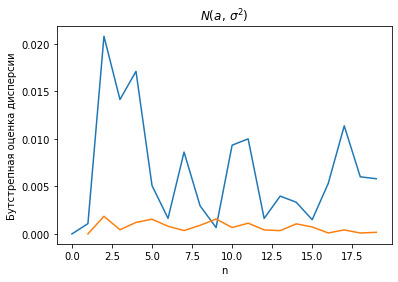

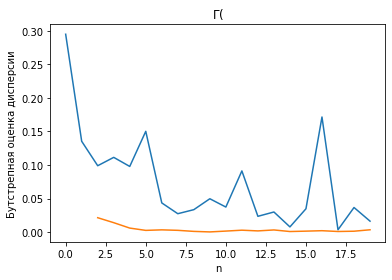

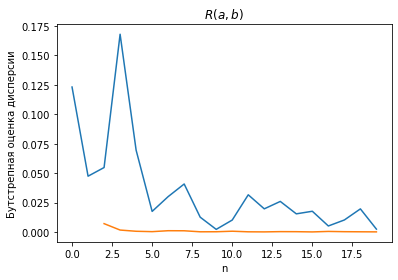

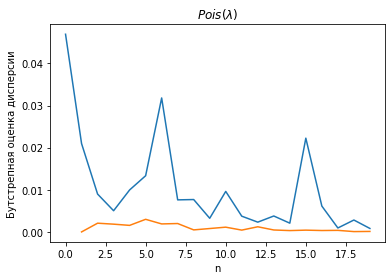

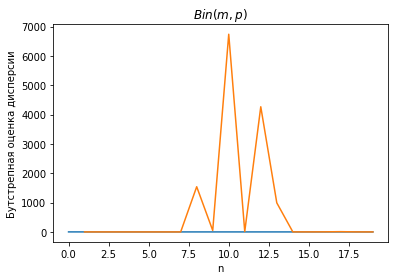

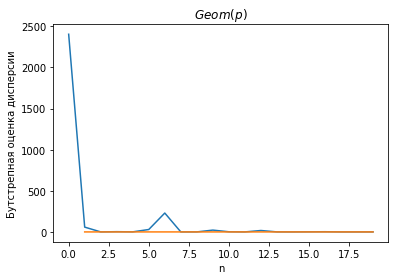

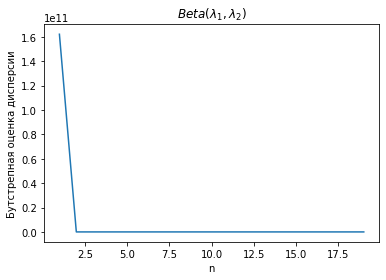

In [32]:
def get_param_bootstrep(distribution, params: np.array): # 
    return [distribution(loc=params[n][0] if len(params.shape) > 1 else params[n], 
                         **{'scale': params[n][1]**0.5} if len(params.shape) > 1 else {}).rvs((K, n+1)) 
            for n in range(0, randvar_count)]

def get_nonparam_bootstrep(distribution, params):
    return [np.random.choice(params[:n, 0] if len(params.shape) > 1 else params[:n], size=(K, n)) for n in range(0, randvar_count)]


s2() вычисляет $s^2()$, а get_bootstrep_variance вычисляет бутсрепную оценку дисперсии
в зависимости от того какую бутстрепную функцию ей дали (параметрическую или не параметрическую).


In [ ]:
def s2(estimators):
    estimator = np.array([randvar_estimators[0] for randvar_estimators in estimators]) if len(estimators.shape) > 1 else estimators
    return (estimator**2).mean() - estimator.mean()**2

def get_bootstrep_variance(distrubution, params, bootstrep_func, estimator_func):
    bootstrep_samples = bootstrep_func(distrubution, params)
    bootstrep_estimators = np.array([get_estimators(sample, estimator_func) for sample in bootstrep_samples])
    return [s2(bootstrep_estimator) for bootstrep_estimator in bootstrep_estimators]


Давайте посмотрим на бутстрепную оценку для каждого распределения и сравним какая лучше.


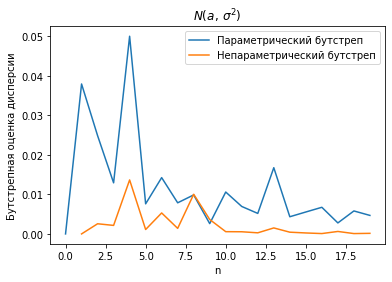

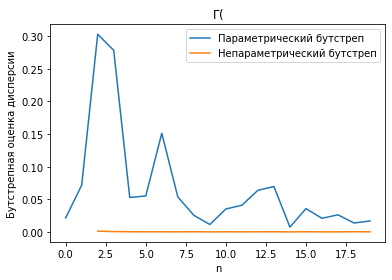

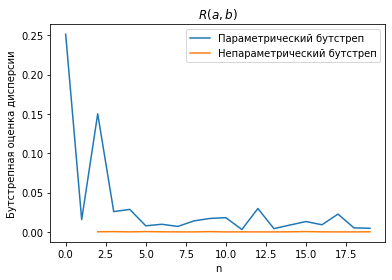

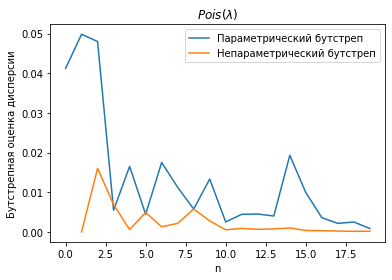

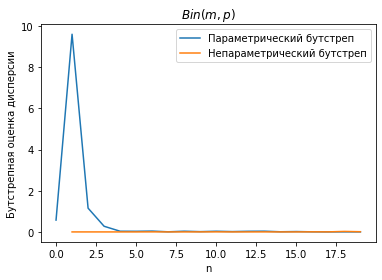

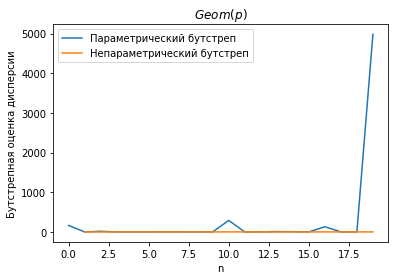

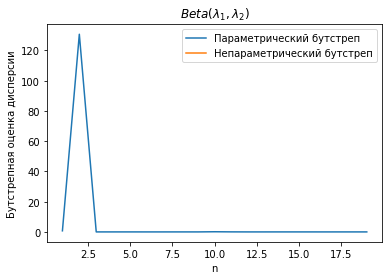

In [35]:
def get_estimators_via_moment_method():
    x = [n for n in range(0, randvar_count)]
    
    for distrib in distribs.items():    
        param_variance = get_bootstrep_variance(sps.norm, distrib[1][params_key], get_param_bootstrep, distrib[1][estimators_func_key])
        nonparam_variance = get_bootstrep_variance(sps.norm, distrib[1][params_key], get_nonparam_bootstrep, distrib[1][estimators_func_key])
        plt.plot(x, param_variance, label='Параметрический бутстреп')
        plt.plot(x, nonparam_variance, label='Непараметрический бутстреп')
        plt.title(distrib[0])
        plt.xlabel('n')
        plt.ylabel('Бутстрепная оценка дисперсии')
        
        plt.legend()
        plt.show()
        
get_estimators_via_moment_method()


Как мы можем убедиться, непараметрический бутстреп показывает почти всегда лучшую оценку 
для всех видов распределений.


# Задача №2



Убедимся, что выборка имеет распределение Коши, только со сдвигом.


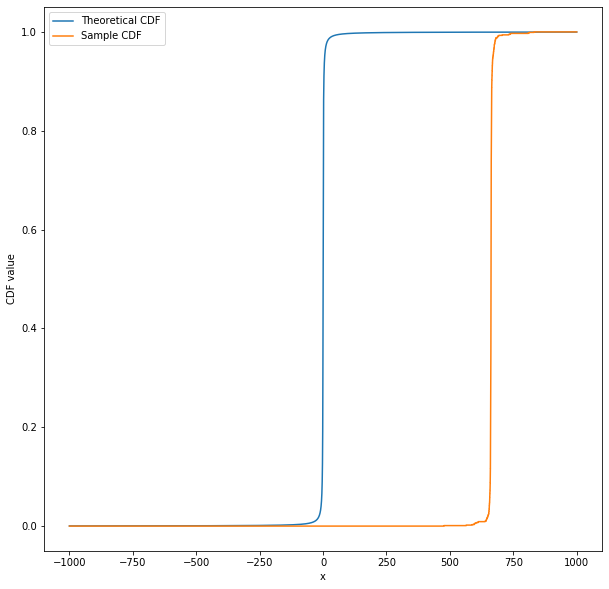

In [51]:
bins = [age for age in np.arange(-1000, 1000.001, 0.01)] # bins for cdf approximation
points = np.array(pd.read_csv('Cauchy.csv').values)

def get_sample_x_and_cdf():
    sample = points
    counts, bin_edges = np.histogram(sample, bins=bins, normed=True)
    cdf = np.cumsum(counts)
    
    return (bin_edges[1:], cdf / max(cdf)) # normed

plt.figure(figsize=(10, 10))
x, cdf = get_sample_x_and_cdf()
plt.plot(x, sps.cauchy.cdf(x), label='Theoretical CDF')
plt.plot(x, cdf, label='Sample CDF')
plt.xlabel('x')
plt.ylabel('CDF value')

plt.legend()
plt.show()


likelyhood() - это функция правдоподобия.

def likelyhood(x, x0):
    return np.sum(np.log(1 / (np.pi * (1 + (x - x0) ** 2))))


В find_emitter_pos() я ищу argmax функции правдоподобия у половины выборки
и у всей.


In [11]:
def find_emitter_pos():
    for n in [500, 1000]:
        rec_value = likelyhood(points[:n], -1000)
        argmax = -1000
        for x0 in np.arange(-1000, 1000.001, 0.01):
            Lp = likelyhood(points[:n], x0)
            if Lp > rec_value:
                argmax = x0
                rec_value = Lp
        
        print('Оценка макс. правдоподобия (n = {0}) = {1}'.format(n, argmax))
    
find_emitter_pos()


Оценка макс. правдоподобия (n = 500) = 662.0399999984884
Оценка макс. правдоподобия (n = 1000) = 662.0499999984884


Как мы можем увидеть, оценка максимального правдоподобия при половине выборки и всей
отличается лишь на 0.01 - не существенно.


# Задача №3


У нас есть нулевые значения (мы используем логарифмическую функцию правдоподобия,
а log(0*smth) неопределён), поэтому изменим нулевые значения на 0.0001 - это никак не влияет на результат, 
ибо у нас шаг 0.001.


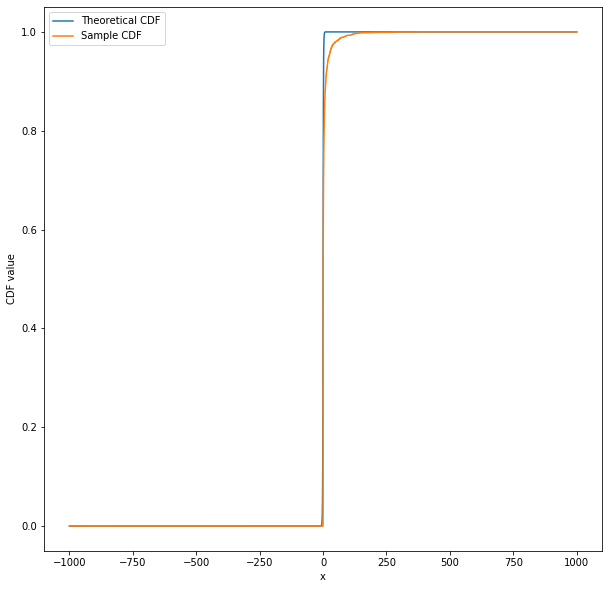

In [52]:
sample = [item + 0.0001 if item == 0 else item for item in np.array(pd.read_csv('Weibull.csv').values)]


Убедимся, что выборка имеет распределение Вейбулла.


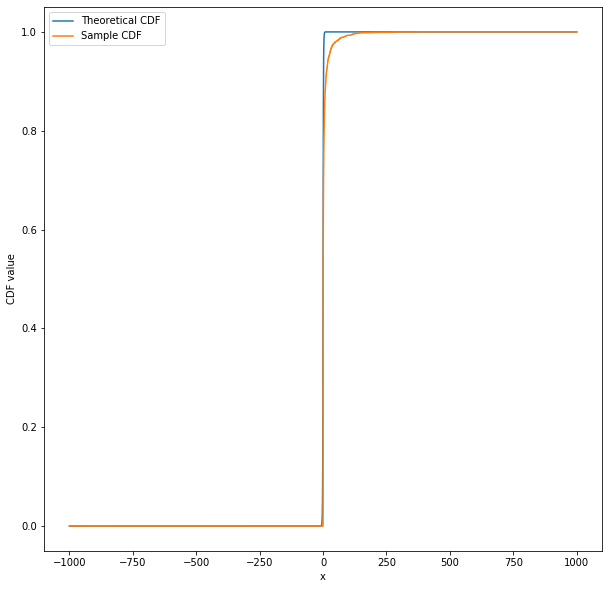

In [53]:
def get_sample_x_and_cdf():
    counts, bin_edges = np.histogram(sample, bins=bins, normed=True)
    cdf = np.cumsum(counts)
    
    return (bin_edges[1:], cdf / max(cdf)) # normed

plt.figure(figsize=(10, 10))
x, cdf = get_sample_x_and_cdf()
plt.plot(x, sps.dweibull.cdf(x, c=1), label='Theoretical CDF')
plt.plot(x, cdf, label='Sample CDF')
plt.xlabel('x')
plt.ylabel('CDF value')

plt.legend()
plt.show()


likelyhood() - это функция правдоподобия.


In [13]:
def likelyhood(x, gamma):
    return np.sum(np.log(gamma * (x ** (gamma - 1)) * np.exp(-x ** gamma)))


В find_emitter_pos() я ищу argmax функции правдоподобия у половины выборки за 4 года
и у всей.


In [55]:
def estimate_parameter():
    for n in [365 * 4, len(sample)]:
        net = np.logspace(-2, 2, num=100000, base=10)
        rec_value = likelyhood(sample[:n], net[0])
        argmax = net[0]
        for gamma in net:
            Lp = likelyhood(sample[:n], gamma)
            if Lp > rec_value:
                argmax = gamma
                rec_value = Lp
        
        print('Оценка макс. правдоподобия (n = {0}) = {1}'.format(n, argmax))
    
estimate_parameter()


Оценка макс. правдоподобия (n = 1460) = 0.37649358067924693
Оценка макс. правдоподобия (n = 3651) = 0.34304692863149194


Как мы можем увидеть, оценка максимального правдоподобия для 4х лет и всей
отличается меньше чем на 0.01.